# Generate plots to show the consistency of sibling peptide ratios

In [1]:
import numpy as np
import pandas as pd

import random
import sys, os
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Read data frame
data_df = pd.read_csv('preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv', sep = '\t', index_col = 0)
print(data_df.shape)

# Eliminate rows that contains more than one protein ID 
protein_ids = data_df['Protein']
no_of_occurences = [v.count(';') for v in protein_ids.values]
indices_to_remove = np.where(np.asarray(no_of_occurences) > 0)[0]
protein_ids[indices_to_remove]

data_df = data_df.drop(indices_to_remove)
print("Non-unique proteins eliminated")
print("Data frame shape: ", data_df.shape)


(14472, 132)
Non-unique proteins eliminated
Data frame shape:  (14472, 132)


In [3]:
data_df = data_df.drop(['R2', 'best mscore', 'numNA',
                        'Charge 1', 'Charge 2', 'Charge 3', 
                        'Charge 4', 'Charge 5', 'Charge 6'], axis = 1)
data_df

,Peptide,Protein,gene symbol,BR_BT549_a,BR_BT549_b,BR_HS578T_a,BR_HS578T_b,BR_MCF7_a,BR_MCF7_b,BR_MDAMB231_a,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,VHCCFYFISPFGHGLKPLDVAFMK,Q15019,2-Sep,67736.6,49688.7,57732.7,63349.2,67598.8,61756.7,62153.9,...,184888.7,157024.0,49126.2,52422.3,37285.8,38880.8,179390.0,148828.3,208464.9,183507.2
3,VNIVPVIAK,Q15019,2-Sep,518728.7,533520.9,419320.4,396663.1,317684.0,366097.8,728045.2,...,623419.3,676515.0,521146.7,505380.1,512520.5,588922.3,836327.0,855696.7,844485.0,958940.3
4,QQPTQFINPETPGYVGFANLPNQVHR,Q15019,2-Sep,104188.8,92525.2,63399.3,58560.5,67032.1,54468.8,86685.3,...,121129.1,111926.1,82168.3,79697.7,86637.4,86046.4,162744.6,140120.6,158263.5,147559.2
5,STLINSLFLTDLYPER,Q15019,2-Sep,223566.3,215846.3,118357.8,122532.4,175728.4,164791.1,311832.8,...,332466.8,303315.1,262901.7,219749.2,238151.9,240847.5,381630.9,323716.2,416258.4,358276.0
6,ASIPFSVVGSNQLIEAK,Q15019,2-Sep,288719.4,234036.4,151627.7,128960.8,180224.5,167356.6,286434.0,...,313338.2,307400.9,267945.1,253036.2,275804.3,244736.9,366880.1,350980.3,423942.9,372984.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,CSVCSEPIMPEPGRDETVR,Q15942,ZYX,73385.3,77362.8,98136.2,94244.5,80880.9,57100.6,84179.0,...,126396.9,115465.7,155045.8,150804.4,91421.7,114228.9,112403.4,117977.3,141709.4,143503.7
22543,QHPVPPPAQNQNQVR,Q15942,ZYX,6218.5,5104.3,13853.8,11655.2,1221.9,1970.2,7877.3,...,9361.0,7864.9,15023.6,16419.2,8675.6,9419.2,8076.9,7327.0,14040.5,13399.5
22544,ALGQLFHIACFTCHQCAQQLQGQQFYSLEGAPYCEGCYTDTLEK,Q15942,ZYX,47392.5,56741.2,49882.2,58919.8,45155.2,34659.3,52234.9,...,72928.2,60348.4,92661.4,76823.6,53861.6,70917.5,72388.0,67317.0,79469.1,86790.7
22545,VSSGYVPPPVATPFSSK,Q15942,ZYX,248700.6,171957.9,310586.4,289012.3,287223.2,185662.4,310782.2,...,233653.1,323083.7,497715.0,479244.1,274234.3,235873.7,332520.8,247520.0,379462.9,321573.3


In [4]:
# Select all pairs of peptide siblings for all proteins
all_proteins = np.unique(data_df['Protein'].values)
all_peptides = data_df['Peptide'].values
print("Number of proteins: ", len(all_proteins))
print("Unique proteins: ", all_proteins)

#For all proteins, record indices of all sibling peptides
sibling_pairs = []

for protein in all_proteins:
    #print("-------")
    #print(protein)
    
    sub_df = data_df[data_df['Protein'] == protein]
    #print(sub_df.iloc[:, :2])
    
    sub_peptides = sub_df['Peptide'].values
    sub_peptide_indices = [np.where(all_peptides == s)[0][0] for s in sub_peptides]

    for i in range(len(sub_peptide_indices)):
        for j in range(i + 1, len(sub_peptide_indices)):
            #print(all_peptides[sub_peptide_indices[i]], "-", all_peptides[sub_peptide_indices[j]])
            pair = [sub_peptide_indices[i], sub_peptide_indices[j]]
            sibling_pairs.append(pair)
            
#Record all sibling pairs
sibling_pairs = np.asarray(sibling_pairs)
print("Number of peptide pairs ", sibling_pairs.shape[0])

#Define all pairs of random runs to sample intensities from
random_run_pairs = list(combinations(np.arange(3, data_df.shape[1]), 2))
print("Total number of random run pairs ", len(random_run_pairs))


Number of proteins:  2122
Unique proteins:  ['A0AV96' 'A0AVT1' 'A0MZ66' ... 'Q9Y6M5' 'Q9Y6M7' 'Q9Y6N5']
Number of peptide pairs  122679
Total number of random run pairs  7140


## Randomly sample sibling ratios

In [5]:
#Super function to sample sibling peptides
def randomSiblingRatios(random_run_count = 1000, supress_print = True):
    #supresses prints
    if not supress_print:
        return randomSiblingRatios_sub(random_run_count)
    
    #enables all prints for debugging
    else:
        with HiddenPrints():
            return randomSiblingRatios_sub(random_run_count)
        
#Function to sample sibling peptides
def randomSiblingRatios_sub(random_run_count = 1000):
    
    #Siblings ratio: 
    #ratio1 = sibling1 in run 1 / sibling1 in run 2
    #ratio2 = sibling2 in run 1 / sibling2 in run 2
    
    final_sibling_ratios_siblings = np.zeros((random_run_count, 2))
    current_sample_count = 0
    while current_sample_count < random_run_count:
        
        print("----------")
        
        #Select a random sibling pair
        random_sibling_pair = random.sample(range(0, len(sibling_pairs) - 1), 1)
        print(data_df.iloc[sibling_pairs[random_sibling_pair][0], :2])
        
        #Select a random experiment pair
        random_experiment_pair = random.sample(range(0, len(random_run_pairs) - 1), 1)
        random_experiment_pair = np.asarray(random_run_pairs)[random_experiment_pair][0]
        print("Random experiment pair: ", random_experiment_pair)
        
        #For each pair, record the quantities
        quantities = data_df.iloc[sibling_pairs[random_sibling_pair][0], random_experiment_pair]
        print(quantities)
        
        #Reject sample if any values are 0
        if np.all(quantities.values != 0) and \
            np.all(~np.isnan(quantities.values)):
            
            quantities = np.array(quantities.values, dtype=np.float64)
            
            #Calculate sibling ratios
            sibling_ratios = quantities[:, 0] / quantities[:, 1]
            print("Sibling ratios: ", sibling_ratios)
            
            #Record final results
            final_sibling_ratios_siblings[current_sample_count] = sibling_ratios
            current_sample_count += 1

    return final_sibling_ratios_siblings


## Randomly sample non-sibling ratios

In [6]:
#Suppressing print statements
class HiddenPrints:
    
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

#Super function to sample non-sibling peptides
def randomNonsiblingRatios(random_run_count = 1000, supress_print = True):
   
    #supresses prints
    if not supress_print:
        return randomNonsiblingRatios_sub(random_run_count)
    
    #enables all prints for debugging
    else:
        with HiddenPrints():
            return randomNonsiblingRatios_sub(random_run_count)
        
#Function to sample non-sibling peptides
def randomNonsiblingRatios_sub(random_run_count = 1000):
    
    final_nonsibling_ratios_siblings = np.zeros((random_run_count, 2))
    current_sample_count = 0
    while current_sample_count < random_run_count:
        
        print("----------")
        
        #Select a random peptide pair
        random_peptide_pair = random.sample(range(0, len(all_peptides) - 1), 2)
        print(data_df.iloc[random_peptide_pair, :2])
        
        #Reject sample if peptides are sibling
        if data_df.iloc[random_peptide_pair[0]]['Protein'] != data_df.iloc[random_peptide_pair[1]]['Protein']:
            
            #Select a random experiment pair
            random_experiment_pair = random.sample(range(0, len(random_run_pairs) - 1), 1)
            random_experiment_pair = np.asarray(random_run_pairs)[random_experiment_pair][0]
            print("Random experiment pair: ", random_experiment_pair)

            #For each pair, record the quantities
            quantities = data_df.iloc[random_peptide_pair, random_experiment_pair]
            print(quantities)

            #Reject sample if any values are 0
            if np.all(quantities.values != 0) and \
               np.all(~np.isnan(quantities.values)):
                
                quantities = np.array(quantities.values, dtype=np.float64)
            
                #Calculate sibling ratios
                sibling_ratios = quantities[:, 0] / quantities[:, 1]
                print("Sibling ratios: ", sibling_ratios)

                #Record final results
                final_nonsibling_ratios_siblings[current_sample_count] = sibling_ratios
                current_sample_count += 1
                
    return final_nonsibling_ratios_siblings





In [7]:
#Define function for create plots
def createPlots(sibling_ratios, nonsibling_ratios, range_start = -6, range_end = 6):
    
    cmap = LinearSegmentedColormap.from_list('mycmap', ['#e7f4fd', '#2d98da', '#3867d6', '#0c2d41'])

    #Create plot for siblings
    g = sns.jointplot(data=np.log10(pd.DataFrame(sibling_ratios, columns = ['Ratio from run 1', 'Ratio from run 2'])), 
                      height = 15,
                      x="Ratio from run 1", y="Ratio from run 2", 
                      kind = 'kde', cmap = cmap, 
                      marginal_kws=dict(color='#2d98da', alpha=0.5), fill=True)

    g.ax_joint.set_xlim([range_start, range_end])
    g.ax_joint.set_ylim([range_start, range_end])
    g.ax_joint.set_xticks(np.arange(range_start, range_end + 1))
    g.ax_joint.set_yticks(np.arange(range_start, range_end + 1))
    g.ax_joint.grid(True)
    g.ax_joint.plot([range_start, range_end], [range_start, range_end], lw = 3, color = 'Black', alpha = 0.5)
    g.fig.suptitle('Distribution of sibling peptide ratios', 
                   fontsize = 30)
    g.fig.subplots_adjust(top=0.95) 
    g.ax_joint.set_xlabel('Intensity ratio for sibling peptide 1', fontsize=30)
    g.ax_joint.set_ylabel('Intensity ratio for sibling peptide 2', fontsize=30)
    label_ticks = []
    for i in range(range_start, range_end + 1):
        label_ticks.append('$10^{' + str(i) + '}$')
    g.ax_joint.set_xticklabels(label_ticks, fontsize = 30)
    g.ax_joint.set_yticklabels(label_ticks, fontsize = 30)
    
    
    #Create plot for non-siblings
    g = sns.jointplot(data=np.log10(pd.DataFrame(nonsibling_ratios, columns = ['Ratio from run 1', 'Ratio from run 2'])), 
                      height = 15,
                      x="Ratio from run 1", y="Ratio from run 2", 
                      kind = 'kde', fill = True, cmap = cmap, 
                      marginal_kws=dict(color='#2d98da', alpha = 0.5))

    g.ax_joint.set_xlim([range_start, range_end])
    g.ax_joint.set_ylim([range_start, range_end])
    g.ax_joint.set_xticks(np.arange(range_start, range_end + 1))
    g.ax_joint.set_yticks(np.arange(range_start, range_end + 1))
    g.ax_joint.grid(True)
    g.ax_joint.plot([range_start, range_end], [range_start, range_end], lw = 3, color = 'Black', alpha = 0.5)
    g.fig.suptitle('Distribution of non-sibling peptide ratios', 
                   fontsize = 30)
    g.fig.subplots_adjust(top=0.95) 
    g.ax_joint.set_xlabel('Intensity ratio for non-sibling peptide 1', fontsize=30)
    g.ax_joint.set_ylabel('Intensity ratio for non-sibling peptide 2', fontsize=30)
    label_ticks = []
    for i in range(range_start, range_end + 1):
        label_ticks.append('$10^{' + str(i) + '}$')
    g.ax_joint.set_xticklabels(label_ticks, fontsize = 30)
    g.ax_joint.set_yticklabels(label_ticks, fontsize = 30)
    

In [8]:
#randomSiblingRatios(random_run_count = 10, supress_print = False)
sibling_ratios = randomSiblingRatios(random_run_count = 10000)

In [9]:
#randomNonsiblingRatios(random_run_count = 10, supress_print = False)
nonsibling_ratios = randomNonsiblingRatios(random_run_count = 10000)

Correlation for siblings:  (0.34015480199278536, 2.561559164414508e-269)
Correlation for non-siblings:  (0.01304111271931061, 0.1922323225277501)
MSE for siblings:  0.2594875668199055
MSE for non-siblings:  0.3989350724481797


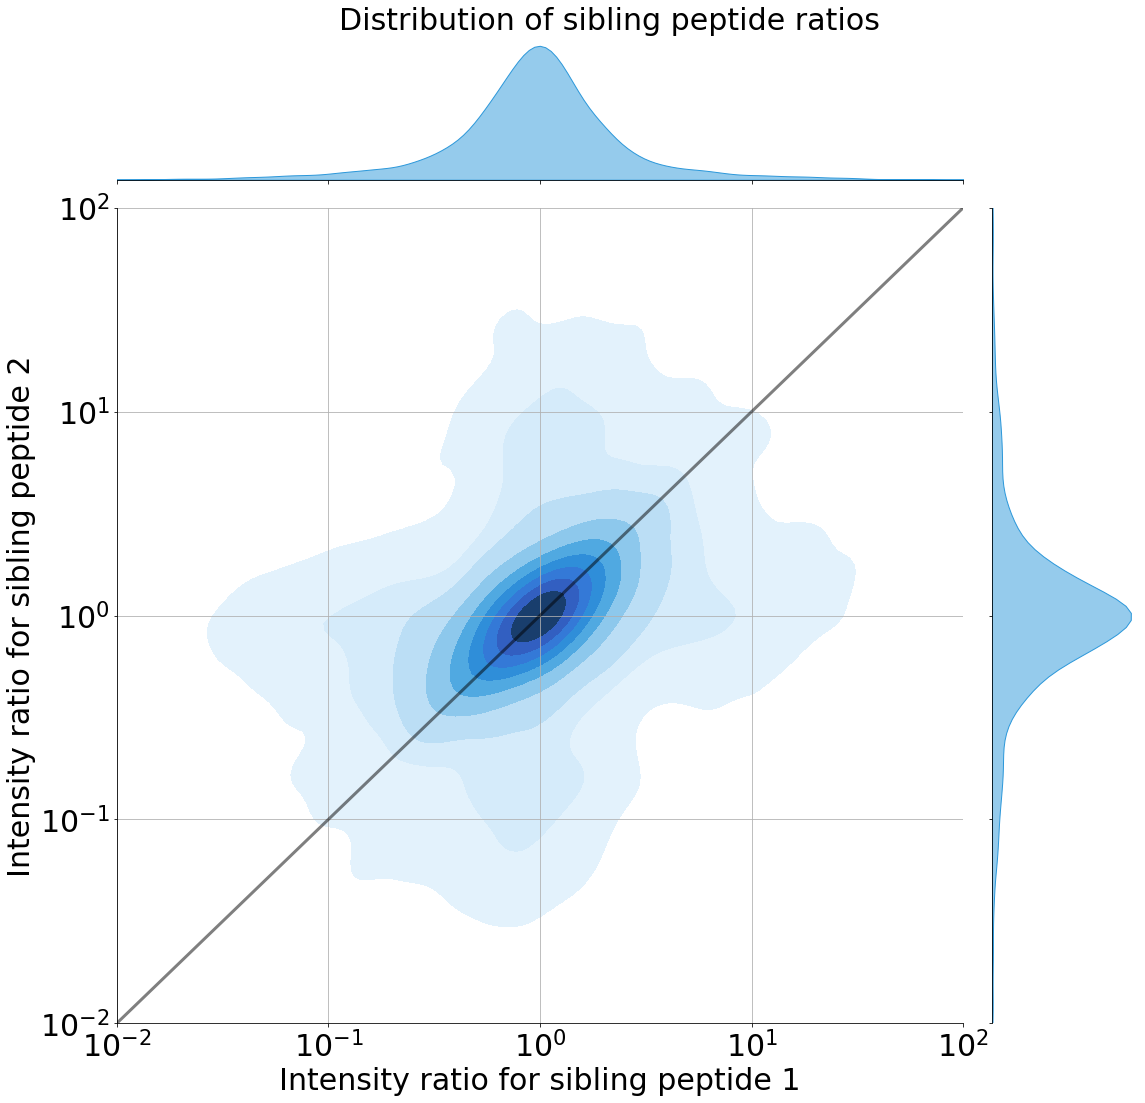

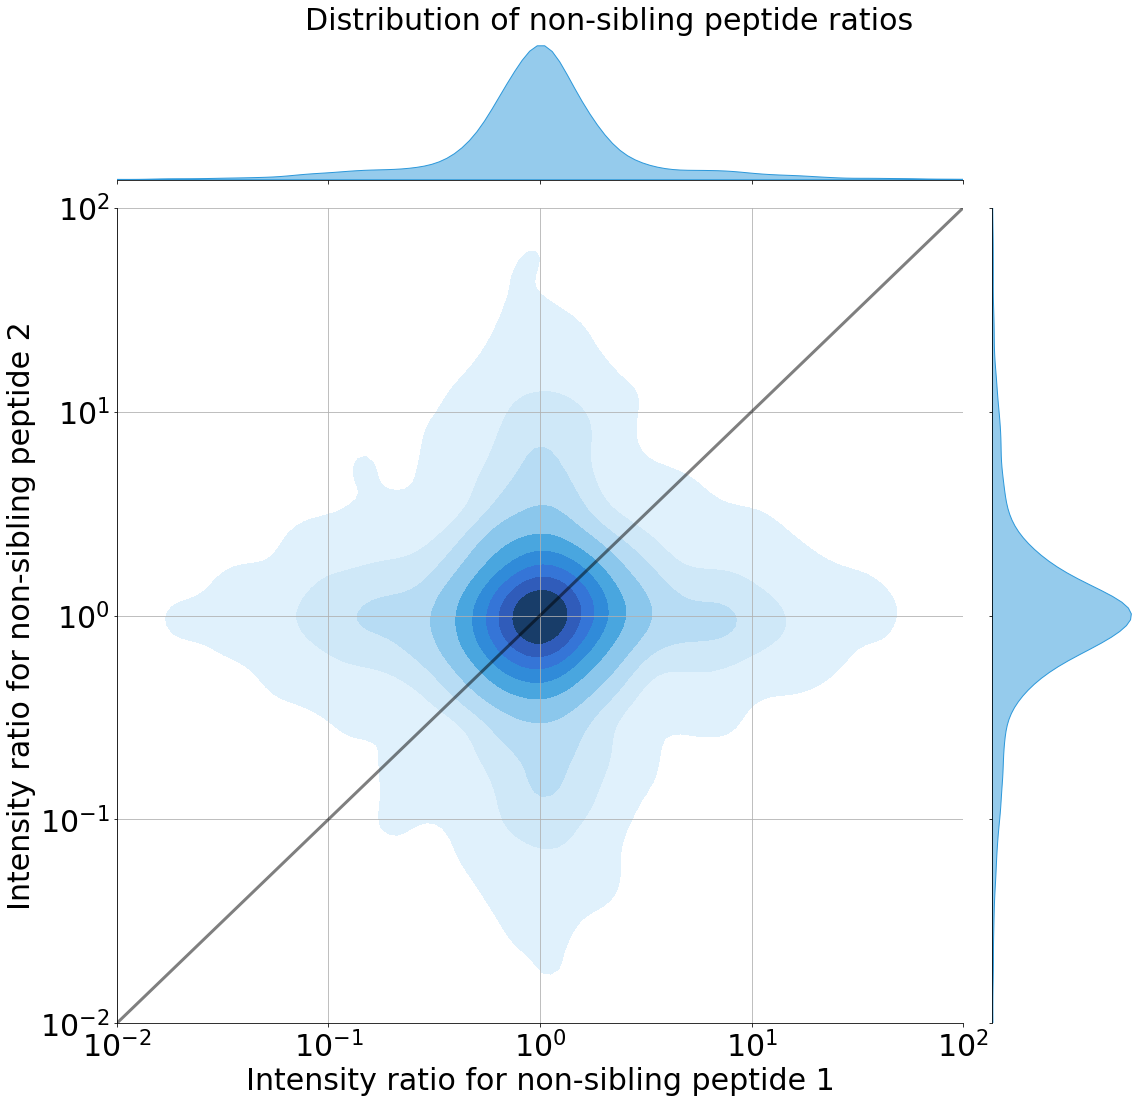

In [10]:
createPlots(sibling_ratios, nonsibling_ratios, -2, 2)

from scipy.stats import pearsonr
print("Correlation for siblings: ", pearsonr(np.log10(sibling_ratios[:, 0]), np.log10(sibling_ratios[:, 1])))
print("Correlation for non-siblings: ", pearsonr(np.log10(nonsibling_ratios[:, 0]), np.log10(nonsibling_ratios[:, 1])))

from sklearn.metrics import mean_squared_error
print("MSE for siblings: ", mean_squared_error(np.log10(sibling_ratios[:, 0]), np.log10(sibling_ratios[:, 1])))
print("MSE for non-siblings: ", mean_squared_error(np.log10(nonsibling_ratios[:, 0]), np.log10(nonsibling_ratios[:, 1])))

